In [28]:
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from glob import glob
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.path as mpath
import matplotlib.ticker as mticker
from matplotlib.patches import ConnectionPatch
plt.rcParams['figure.facecolor'] = 'white'
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

In [2]:
def prepro(ds):
    return ds.isel(y=slice(800, None))

In [3]:
def latitude_labels(ax, ds):    
    labels = [int(item._x) for item in ax.get_xticklabels()]
    labels_coord = [np.round(ds.nav_lat.isel(diag=label).values) for label in labels ]
    for il in range(0,len(labels)):
        if labels[il] % 200:
            labels_coord[il]=''
    ax.set_xticklabels(labels_coord)

In [4]:
def calc_dy(da):
    ddy = xr.Dataset(coords={"deptht": da.deptht, 
                     "diag": 0.5 * (da.diag.values[0:-1] + da.diag.values[1::])})
    R = 6371000.
    dlon = np.radians(da.nav_lon.values[1::]) - np.radians(da.nav_lon.values[0:-1])
    lat1 = np.radians(da.nav_lat.values[0:-1])
    lat2 = np.radians(da.nav_lat.values[1::])
    dlat = lat2 - lat1
    a = ((np.sin(dlat / 2.) ** 2.) + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon / 2.) ** 2.))
    c = 2 * np.arcsin(np.sqrt(a))
    dy = R * c * 1e3
    ddy = ddy.assign_coords({"dy": ("diag", dy)})
    ddy = ddy.assign_coords({"y": ("diag", np.cumsum(dy))})
    ddy["drhody"] = (("deptht", "diag"), (da.values[:, 1::] - da.values[:, 0:-1]) / dy)
    ddy = ddy.assign_coords({"nav_lon": ("diag", 0.5 * (da.nav_lon.values[0:-1] + da.nav_lon.values[1::]))})
    ddy = ddy.assign_coords({"nav_lat": ("diag", 0.5 * (da.nav_lat.values[0:-1] + da.nav_lat.values[1::]))})
    return ddy

In [5]:
grid_files = ["/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mask.nc", 
              "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mesh_hgr.nc",
              "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mesh_zgr.nc"]

In [7]:
grid = xr.open_mfdataset(grid_files, parallel=True, preprocess=prepro)

In [8]:
ice = xr.open_mfdataset('/data0/project/drakkar/USERS/jrieck/transects/sithic_transect_0.nc')
iceREF = ice.sithic_ref_t0.mean("time_counter")
iceFUT = ice.sithic_fut_t0.mean("time_counter")
rho = xr.open_mfdataset("/data0/project/drakkar/USERS/jrieck/transects/density_transect_0.nc")
densityREF = rho.rhop_sig0_ref_t0.mean("time_counter")
densityFUT = rho.rhop_sig0_fut_t0.mean("time_counter")

In [9]:
drhodyREF = calc_dy(densityREF)
drhodyFUT = calc_dy(densityFUT)

/tmp/ipykernel_3483/4030930838.py:14: RuntimeWarning: invalid value encountered in divide
  ddy["drhody"] = (("deptht", "diag"), (da.values[:, 1::] - da.values[:, 0:-1]) / dy)


In [10]:
ww_data_filesREF = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-windwork/" 
                                + "/CREG12.L75-REF08_clim*.nc"))
ww_data_filesFUT = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-windwork" 
                                + "/CREG12.L75-FUT08_clim*.nc"))
psi_data_files = sorted(glob("/data0/project/drakkar/USERS/jrieck/stream_function.nc"))

In [11]:
wwREF = xr.open_mfdataset(ww_data_filesREF, parallel=True)
wwFUT = xr.open_mfdataset(ww_data_filesFUT, parallel=True)
psi = xr.open_mfdataset(psi_data_files, parallel=True).isel(y=slice(300, None))

In [12]:
psiREFplot = psi.Streamfunction_REF.where(psi.Streamfunction_REF!=0).compute()
psiREFplot[632:634, 806] = np.nan
psiREFplot[805:807, 766:768] = np.nan
psiFUTplot = psi.Streamfunction_FUT.where(psi.Streamfunction_FUT!=0).compute()
psiFUTplot[554:558, 760:830] = np.nan
psiFUTplot[654:656, 760:830] = np.nan
psiFUTplot[741:743, 760:830] = np.nan
psiFUTplot[791, 760:830] = np.nan
psiFUTplot[811, 760:830] = np.nan
psiDIFFplot = (psiFUTplot - psiREFplot).compute()
psiDIFFplot[746, 760:830] = np.nan
psiDIFFplot[797, 760:830] = np.nan
psiDIFFplot[818, 760:830] = np.nan

In [13]:
totREFu = wwREF.sozotwot.mean("time_counter").compute()
totREFv = wwREF.sometwot.mean("time_counter").compute()
totFUTu = wwFUT.sozotwot.mean("time_counter").compute()
totFUTv = wwFUT.sometwot.mean("time_counter").compute()
totDIFFu = totFUTu - totREFu
totDIFFv = totFUTv - totREFv

In [14]:
totREF = totREFu + totREFv
totFUT = totFUTu + totFUTv
totDIFF = totFUT - totREF

In [15]:
for ds in [psiREFplot, psiFUTplot, totREFu, totFUTu, totDIFFu,
           totREFv, totFUTv, totDIFFv, totREF, totFUT, totDIFF]:
    ds = ds.assign_coords({"nav_lon": grid.nav_lon, "nav_lat": grid.nav_lat})

In [16]:
def map_config(ax):
    ax.set_extent([-180, 180, 67, 90], ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor="silver")
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.invert_yaxis()
    ax.invert_xaxis()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, y_inline=True,
                      linewidth=1, color='gray', alpha=0.7, linestyle='--')
    gl.xlabel_style = {'fontsize': 8}
    gl.ylabel_style = {'fontsize': 8}
    gl.ylocator = mticker.FixedLocator([70, 75, 80, 85])
    gl.xlocator = mticker.FixedLocator([-90, 0, 90, 180])
    plt.draw()
    for lab in gl.ylabel_artists:
        delete_label = lab.get_position()[0] < 0
        if delete_label:
            lab.set_visible(False)
    return gl

In [17]:
proj = ccrs.NearsidePerspective(central_longitude=170, central_latitude=75, satellite_height=35785831)

In [18]:
qs = 30
x = totREF.nav_lon.values[0::qs, 0::qs]
y = totREF.nav_lat.values[0::qs, 0::qs]

In [19]:
totREFuNORM = totREFu / ((totREFu**2 + totREFv**2)**0.5)
totREFvNORM = totREFv / ((totREFu**2 + totREFv**2)**0.5)
totFUTuNORM = totFUTu / ((totFUTu**2 + totFUTv**2)**0.5)
totFUTvNORM = totFUTv / ((totFUTu**2 + totFUTv**2)**0.5)
totDIFFuNORM = totDIFFu / ((totDIFFu**2 + totDIFFv**2)**0.5)
totDIFFvNORM = totDIFFv / ((totDIFFu**2 + totDIFFv**2)**0.5)

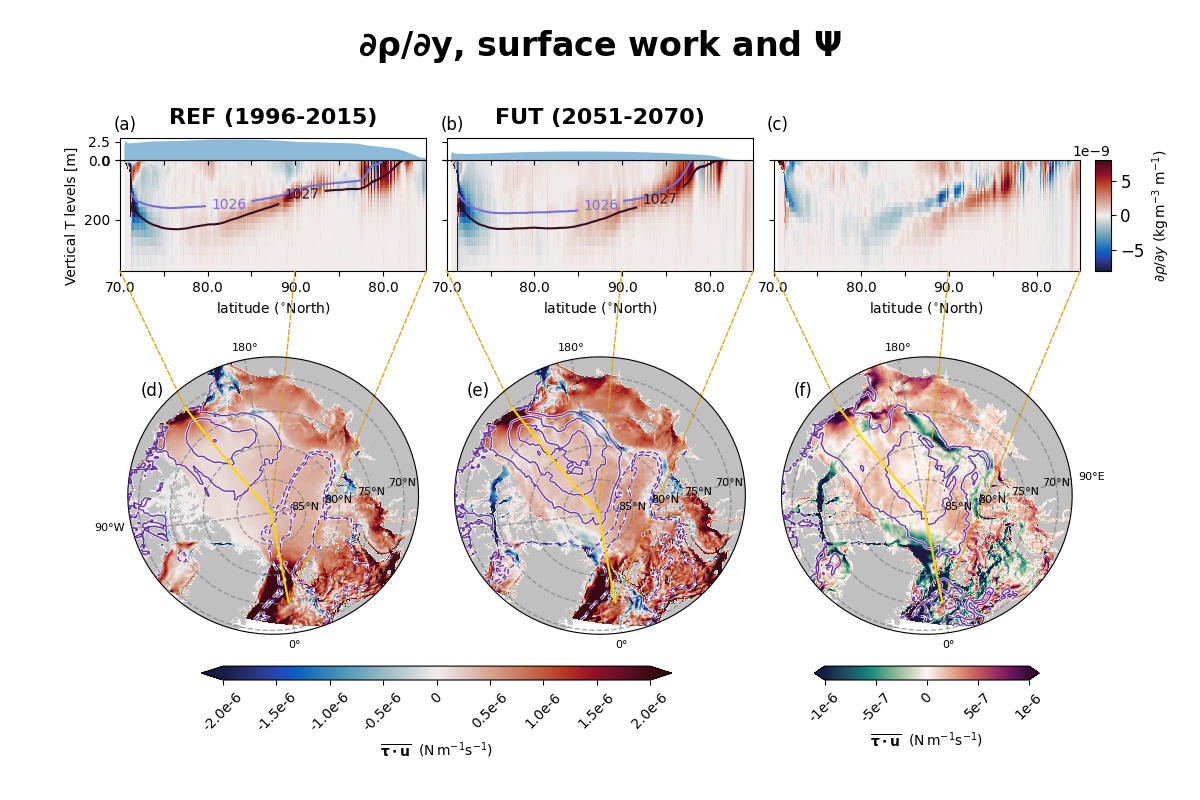

In [65]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(4, 24, height_ratios=[0.4, 0.08, 1, 0.05])

ax01 = fig.add_subplot(gs[0, 0:8])
ax02 = fig.add_subplot(gs[0, 8:16])
ax03 = fig.add_subplot(gs[0, 16:24])
ax1 = fig.add_subplot(gs[2, 0:8], projection=proj)
ax2 = fig.add_subplot(gs[2, 8:16], projection=proj)
ax3 = fig.add_subplot(gs[2, 16:24], projection=proj)
axcb1 = fig.add_subplot(gs[3, 2:14])
axcb2 = fig.add_subplot(gs[3, 17:23])

d1 = drhodyREF.drhody.plot(x='diag', yincrease=False, ax=ax01, rasterized=True,
                           add_colorbar=False, vmin=-8e-9, vmax=8e-9, cmap=cmo.balance)
cs1 = densityREF.where(densityREF> 1000).plot.contour(x='diag', yincrease=False, ax=ax01, 
                                                      vmin=1020, vmax=1030,
                                                      cmap=cmo.dense, levels=[1024,1026,1027])
ax01.clabel(cs1, inline=1, fontsize=10)
ice_ax1 = ax01.inset_axes([0, 1, 1, 0.2])
ice_ax1.fill_between(iceREF.diag, iceREF * 0, iceREF, alpha=0.5)

d2 = drhodyFUT.drhody.plot(x='diag', yincrease=False, ax=ax02, rasterized=True,
                           add_colorbar=False, vmin=-8e-9, vmax=8e-9, cmap=cmo.balance)
cs2 = densityFUT.where(densityFUT>1000).plot.contour(x='diag', yincrease=False, ax=ax02, 
                                                      vmin=1020, vmax=1030,
                                                      cmap=cmo.dense, levels=[1024,1026,1027])
ax02.clabel(cs2, inline=1, fontsize=10)
ice_ax2 = ax02.inset_axes([0, 1, 1, 0.2])
ice_ax2.fill_between(iceFUT.diag, iceFUT * 0, iceFUT, alpha=0.5)

d3 = (drhodyFUT - drhodyREF).drhody.plot(x='diag', yincrease=False, ax=ax03, rasterized=True,
                                         add_colorbar=False, vmin=-8e-9, vmax=8e-9, cmap=cmo.balance)

t1 = totREF.plot(x='nav_lon', y='nav_lat', cmap=cmo.balance, 
                  vmin=-2e-6, vmax=2e-6,
                  ax=ax1, transform=ccrs.PlateCarree(), rasterized=True, 
                  zorder=1, add_colorbar=False)
t2 = totFUT.plot(x='nav_lon', y='nav_lat', cmap=cmo.balance, 
                  vmin=-2e-6, vmax=2e-6,
                  ax=ax2, transform=ccrs.PlateCarree(), rasterized=True, 
                  zorder=1, add_colorbar=False)
t3 = totDIFF.plot(x='nav_lon', y='nav_lat', cmap=cmo.curl, 
                  vmin=-1e-6, vmax=1e-6,
                  ax=ax3, transform=ccrs.PlateCarree(), rasterized=True, 
                  zorder=1, add_colorbar=False)

p1 = psiREFplot.plot.contour(x='nav_lon', y='nav_lat', levels=[-4, -2, 0, 2, 4], 
                             colors="ghostwhite", linewidths=2,
                             ax=ax1, transform=ccrs.PlateCarree(), zorder=2)
p1 = psiREFplot.plot.contour(x='nav_lon', y='nav_lat', levels=[-4, -2, 0, 2, 4], 
                             colors="rebeccapurple", linewidths=1,
                             ax=ax1, transform=ccrs.PlateCarree(), zorder=3)
p2 = psiFUTplot.plot.contour(x='nav_lon', y='nav_lat', levels=[-4, -2, 0, 2, 4], 
                             colors="ghostwhite", linewidths=2,
                             ax=ax2, transform=ccrs.PlateCarree(), zorder=2)
p2 = psiFUTplot.plot.contour(x='nav_lon', y='nav_lat', levels=[-4, -2, 0, 2, 4], 
                             colors="rebeccapurple", linewidths=1,
                             ax=ax2, transform=ccrs.PlateCarree(), zorder=3)
p3 = psiDIFFplot.plot.contour(x='nav_lon', y='nav_lat', levels=[-4, -2, 0, 2, 4], 
                              colors="ghostwhite", linewidths=2,
                              ax=ax3, transform=ccrs.PlateCarree(), zorder=2)
p3 = psiDIFFplot.plot.contour(x='nav_lon', y='nav_lat', levels=[-4, -2, 0, 2, 4], 
                              colors="rebeccapurple", linewidths=1,
                              ax=ax3, transform=ccrs.PlateCarree(), zorder=3)

gl = [map_config(ax) for ax in [ax1, ax2, ax3]];
for i in np.arange(0, 3):
    l = len(gl[i].label_artists)
    for j in np.arange(0, l):
        a = gl[i].label_artists[j]
        if i in [0, 1]:
            if a.get_text() == "90°E":
                a.set_visible(False)
        if i in [1, 2]:
            if a.get_text() == "90°W":
                a.set_visible(False)
                
[ax.plot(drhodyREF.nav_lon, drhodyREF.nav_lat, transform=ccrs.PlateCarree(), color="gold", zorder=6) 
 for ax in [ax1, ax2, ax3]]
xd1, yd1 = proj.transform_point(drhodyREF.nav_lon[0], drhodyREF.nav_lat[0], ccrs.Geodetic())
xd2, yd2 = proj.transform_point(0, 90, ccrs.Geodetic())
xd3, yd3 = proj.transform_point(drhodyREF.nav_lon[-1], drhodyREF.nav_lat[-1], ccrs.Geodetic())
xa1 = 0; ya1 = 370
xa2 = int((drhodyREF.nav_lat - 90).argmax()); ya2 = 370
xa3 = len(drhodyREF.diag); ya3 = 370
for axx1, axx2 in zip([ax01, ax02, ax03], [ax1, ax2, ax3]):
    conad1 = ConnectionPatch(xyA=[xa1, ya1], xyB=[xd1, yd1], coordsA="data", coordsB="data",
                             axesA=axx1, axesB=axx2, color="goldenrod", linestyle="--")
    conad2 = ConnectionPatch(xyA=[xa2, ya2], xyB=[xd2, yd2], coordsA="data", coordsB="data",
                             axesA=axx1, axesB=axx2, color="goldenrod", linestyle="--")
    conad3 = ConnectionPatch(xyA=[xa3, ya3], xyB=[xd3, yd3], coordsA="data", coordsB="data",
                             axesA=axx1, axesB=axx2, color="goldenrod", linestyle="--")
    axx2.add_artist(conad1)
    axx2.add_artist(conad2)
    axx2.add_artist(conad3)

[ax.set_xlim(0, len(drhodyREF.diag)) for ax in [ax01, ax02, ax03]]
[ax.set_ylim(370, 0) for ax in [ax01, ax02, ax03]]
[ax.set_xlim((0, max(iceREF.diag))) for ax in [ice_ax1, ice_ax2]]
[ax.set_ylim((0, 3)) for ax in [ice_ax1, ice_ax2]]
[ax.set_xticks(np.arange(0, len(drhodyREF.diag), 100)) for ax in [ax01, ax02, ax03]]
[ax.xaxis.set_ticklabels([]) for ax in [ice_ax1, ice_ax2]]
[ax.yaxis.set_ticklabels([]) for ax in [ax02, ax03, ice_ax2]]
[ax.set_ylabel("") for ax in [ax02, ax03]]
[ax.set_xlabel(r"latitude ($^{\circ}$North)") for ax in [ax01, ax02, ax03]]

[latitude_labels(ax, drhodyREF) for ax in [ax01, ax02, ax03]]

fig.text(0.5, 0.93, r"$\bf{\partial \rho / \partial y}$, surface work and $\bf{\Psi}$", 
         fontsize=24, fontweight="bold", ha="center")

ice_ax1.set_title("REF (1996-2015)", fontsize=16, fontweight="bold", pad=10)
ice_ax2.set_title("FUT (2051-2070)", fontsize=16, fontweight="bold", pad=10)

[ax.text(-15, -100, t, fontsize=12) 
 for ax, t in zip([ax01, ax02, ax03], ["(a)", "(b)", "(c)"])]
[ax.text(-140, 64, t, fontsize=12, transform=ccrs.PlateCarree()) 
 for ax, t in zip([ax1, ax2, ax3], ["(d)", "(e)", "(f)"])]

cb1 = plt.colorbar(t1, cax=axcb1, orientation="horizontal", extend="both")
axcb1.set_xticks([-2e-6, -1.5e-6, -1e-6, -0.5e-6, 0, 0.5e-6, 1e-6, 1.5e-6, 2e-6])
axcb1.set_xticklabels(["-2.0e-6", "-1.5e-6", "-1.0e-6", "-0.5e-6", "0",
                       "0.5e-6", "1.0e-6", "1.5e-6", "2.0e-6"], rotation=45, ha='center')
axcb1.set_xlabel(r"$\overline{\bf{\tau \cdot u}}$  (N$\,$m$^{-1}$s$^{-1}$)")
cb2 = plt.colorbar(t3, cax=axcb2, orientation="horizontal", extend="both")
axcb2.set_xticks([-1e-6, -0.5e-6, 0, 0.5e-6, 1e-6])
axcb2.set_xticklabels(["-1e-6", "-5e-7", "0", "5e-7", "1e-6"], rotation=45, ha='center')
axcb2.set_xlabel(r"$\overline{\bf{\tau \cdot u}}$  (N$\,$m$^{-1}$s$^{-1}$)")

cax = ax03.inset_axes([1.05, 0, 0.05, 1])
cbar = plt.colorbar(d1, cax=cax,orientation='vertical')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r"$\partial \rho / \partial y$ (kg$\,$m$^{-3}\,\,$m${^{-1}}$)")

plt.subplots_adjust(wspace=1, hspace=0.3, bottom=0.15, top=0.8, left=0.1, right=0.9)

plt.savefig("figures/Figure_3_grad_rho_psi_work.png", dpi=300)